# Ensemble: pr/prra/prsn (over sea-ice and ocean)

## Imports & defaults

In [1]:
import libs.analysis 
import libs.ensemble
import libs.local
import libs.plot
import libs.vars
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import warnings
import xarray

matplotlib.rcParams.update({ 'font.size': 18 })
warnings.filterwarnings('ignore')

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'Amon'
experiment = 'ssp585'
variable_id = 'pr'

conf = [v for v in libs.vars.variables() if v['variable_id'] == variable_id][0]
time_series_text = '''total precipitation (solid), rainfall (dashed), snowfall (dashdot), 
and evaporation (dotted) over sea-ice and ocean'''

time_series_weighted_method = conf['weighting_method']
time_series_units = conf['units']
time_series_y_label = f'Precipitation ({time_series_units})'
time_series_y_range = (0, 2.25)
time_series_y_range_monthly = (0, 3)
time_series_process = lambda x: x

In [3]:
ensemble_pr_time_series = time_series_process(
    libs.local.get_ensemble_series(variable_id, experiment)
)

# ----- prra -----
ensemble_prra_time_series = time_series_process(
    libs.local.get_ensemble_series('prra', experiment)
)

# ----- prsn -----
ensemble_prsn_time_series = time_series_process(
    libs.local.get_ensemble_series('prsn', experiment)
)
for variable in ensemble_prsn_time_series:
    ensemble_prsn_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashdot' }

time_slices = libs.vars.default_time_slices()

## Time series

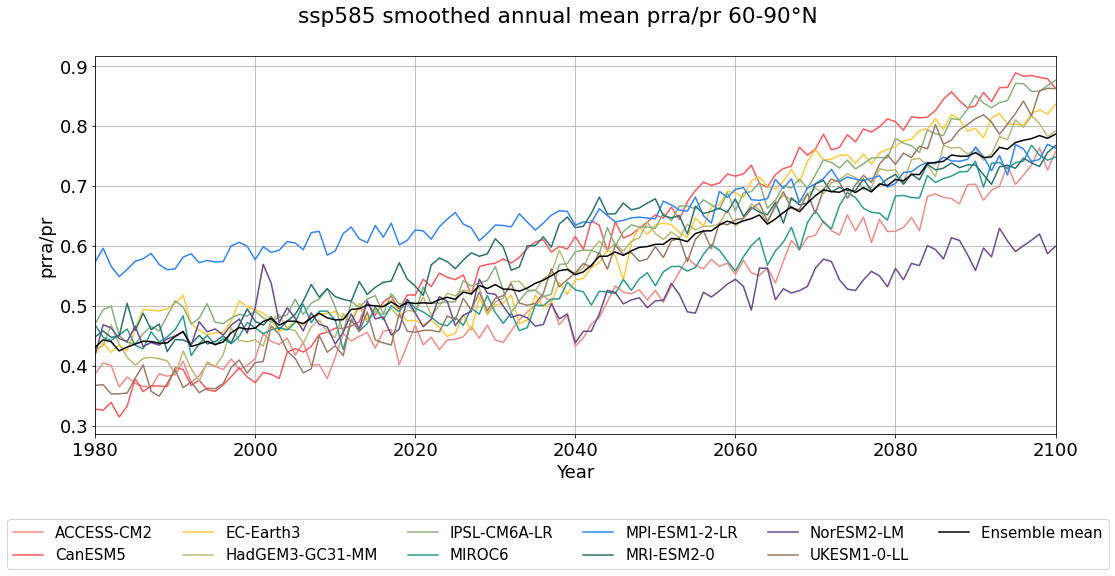

In [4]:
prra_annual = ensemble_prra_time_series.groupby('time.year').mean('time')
pr_annual = ensemble_pr_time_series.groupby('time.year').mean('time')
prra_pr_ratio = prra_annual / pr_annual
prra_pr_ratio = libs.ensemble.calc_variable_mean(prra_pr_ratio)

for key in prra_pr_ratio:
    prra_pr_ratio[key].attrs['plot_kwargs'] = { 'linestyle': 'solid' }

libs.plot.time_series_from_vars(
    [
        prra_pr_ratio
    ],
    title=f'{experiment} smoothed annual mean prra/pr 60-90°N',
    xattr='year',
    ylabel='prra/pr'
);

## Monthly variability

### Ratio prra/pr

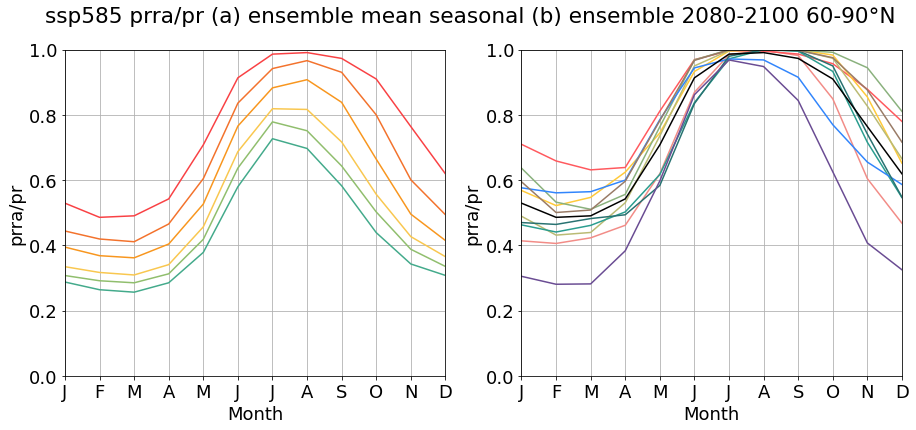

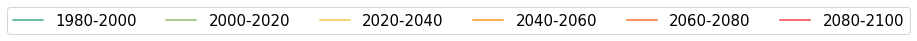

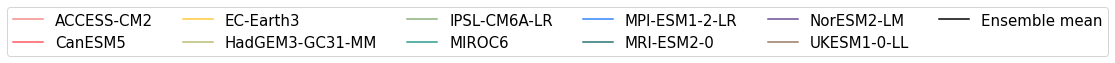

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.flatten()
fig.suptitle(
    f'''{experiment} prra/pr (a) ensemble mean seasonal (b) ensemble 2080-2100 60-90°N'''
)

vars_series = [
    { 'calc_mean': True, 'data': ensemble_prra_time_series / ensemble_pr_time_series }
]

arr = []
for item in vars_series:
    for s in libs.vars.time_slices_20y():
        s_label = s['label']
        data_slice = item['data'].sel(**s['slice']).groupby('time.month').mean('time')
        data_slice['Ensemble mean'].attrs['color'] = s['color']
        data_slice['Ensemble mean'].attrs['label'] = s['label']

        arr.append(data_slice)

libs.plot.monthly_variability(
    arr,
    ax=axes[0],
    fig=fig,
    show_legend=False,
    variables=['Ensemble mean'],
    ylabel='prra/pr',
    yrange=(0, 1)
);

arr = []
for item in vars_series:
    s = time_slices[2]
    s_label = s['label']
    s_prra_pr = item['data'].sel(**s['slice']).groupby('time.month').mean('time')
    arr.append(s_prra_pr)

libs.plot.monthly_variability(
    arr,
    ax=axes[1],
    fig=fig,
    show_legend=False,
    ylabel='prra/pr',
    yrange=(0, 1)
);

libs.plot.legend_standalone(
    fig,
    legend_confs=[
        { 'ncol': 6, 'exclude': [] },
        { 'ncol': 6, 'exclude': [] },
    ]
)

### Overall seasonal cycle

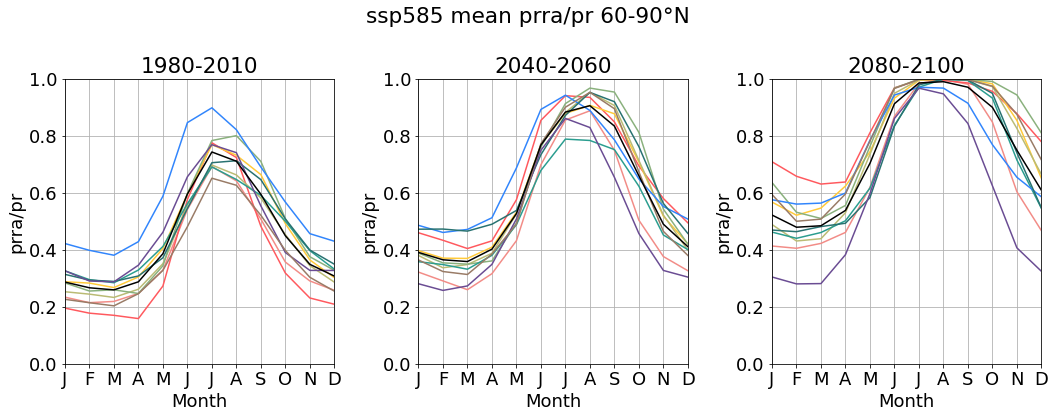

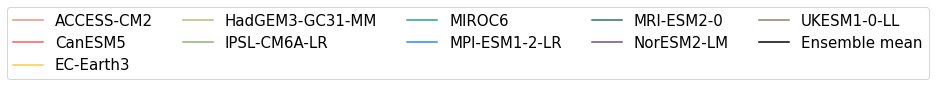

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs = axs.flatten()
fig.suptitle(f'{experiment} mean prra/pr 60-90°N')

ds_prra_pr = ensemble_prra_time_series / ensemble_pr_time_series

for i, s in enumerate(time_slices):
    s_label = s['label']
    
    time_slice = ds_prra_pr.sel(**s['slice']).groupby('time.month').mean('time')
    time_slice = libs.ensemble.calc_variable_mean(time_slice)
    time_slice = time_slice.fillna(0)

    libs.plot.monthly_variability(
        time_slice,
        ax=axs[i],
        fig=fig,
        show_legend=False,
        ylabel='prra/pr',
        yrange=(0, 1)
    );
    
    axs[i].set_title(s_label)
    

libs.plot.legend_standalone(
    fig,
    legend_confs=[
        { 'ncol': 5, 'exclude': [] },
        { 'ncol': 5, 'exclude': [], 'hide': True },
        { 'ncol': 5, 'exclude': [], 'hide': True }
    ]
)

fig.tight_layout()

### Regional

In [7]:
regions = libs.local.get_ensemble_regional_series('pr', experiment)
regions_prra = libs.local.get_ensemble_regional_series('prra', experiment)

ensemble_pr_time_series.attrs['region'] = 'All'
ensemble_prra_time_series.attrs['region'] = 'All'

regions_inc_all = [ensemble_pr_time_series, *regions]
regions_prra_inc_all = [ensemble_prra_time_series, *regions_prra]

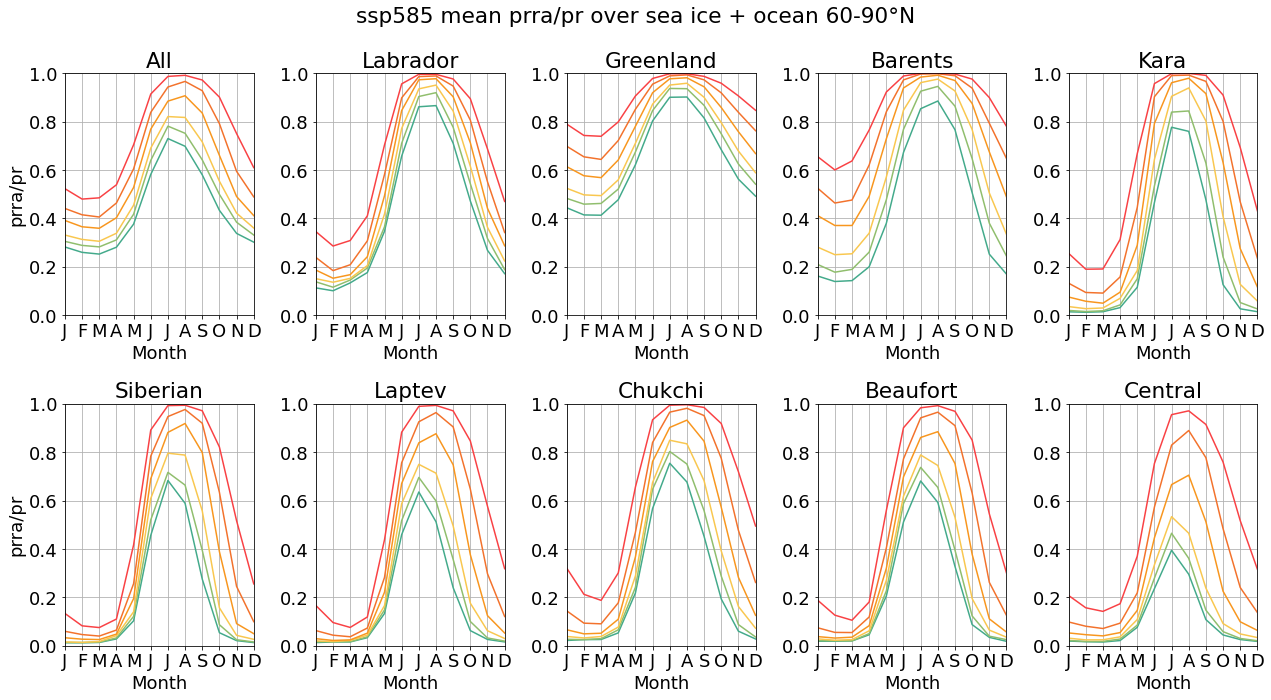

In [8]:
fig, axs = plt.subplots(2, 5, figsize=(18, 10))
axs = axs.flatten()
fig.suptitle(f'{experiment} mean prra/pr over sea ice + ocean 60-90°N')

for i, ds_region_pr in enumerate(regions_inc_all):
    ds_region = regions_prra_inc_all[i] / ds_region_pr
    ds_region.attrs['region'] = ds_region_pr.attrs['region']
    
    arr_region = []
    for s in libs.vars.time_slices_20y():
        s_label = s['label']
        data_slice = ds_region.sel(**s['slice']).groupby('time.month').mean('time')
        data_slice = libs.ensemble.calc_variable_mean(data_slice)
        data_slice = data_slice.fillna(0)
        data_slice['Ensemble mean'].attrs['color'] = s['color']
        data_slice['Ensemble mean'].attrs['label'] = s['label']
        arr_region.append(data_slice)
    
    libs.plot.monthly_variability(
        arr_region,
        ax=axs[i],
        fig=fig,
        show_legend=False,
        variables=['Ensemble mean'],
        ylabel=('prra/pr' if i % 5 == 0 else ''),
        yrange=(0, 1)
    )
    
    axs[i].set_title(ds_region.attrs['region'])
    
fig.tight_layout()

### Seasonal anomaly

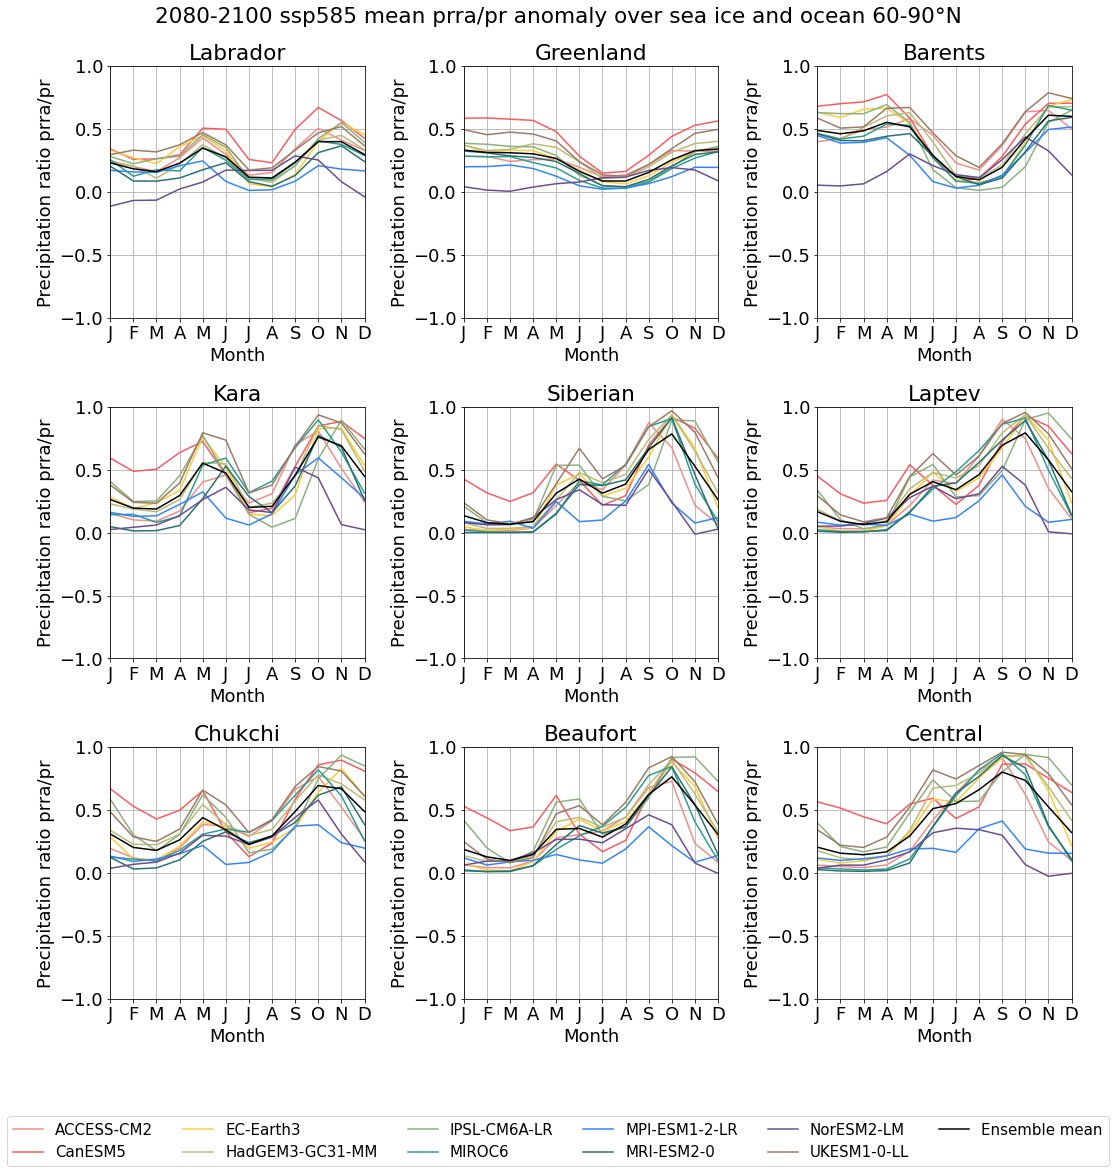

In [9]:
for s in time_slices[2:]:
    s_label = s['label']
    arr = []
    for i, data in enumerate(regions):
        data_pr_ratio = libs.analysis.climatology_monthly(
            regions_prra[i] / data, 
            '1980-01-01', 
            '2011-01-01', 
            relative=False
        )
        data_pr_ratio = data_pr_ratio.sel(**s['slice']).groupby('time.month').mean('time')
        data_pr_ratio.attrs = data.attrs
        arr.append([
            data_pr_ratio
        ])

    libs.plot.monthly_variability_regional(
        arr,
        title=f'{s_label} {experiment} mean prra/pr anomaly over sea ice and ocean 60-90°N',
        ylabel='Precipitation ratio prra/pr',
        yrange=(-1, 1)
    )

## Rain season length

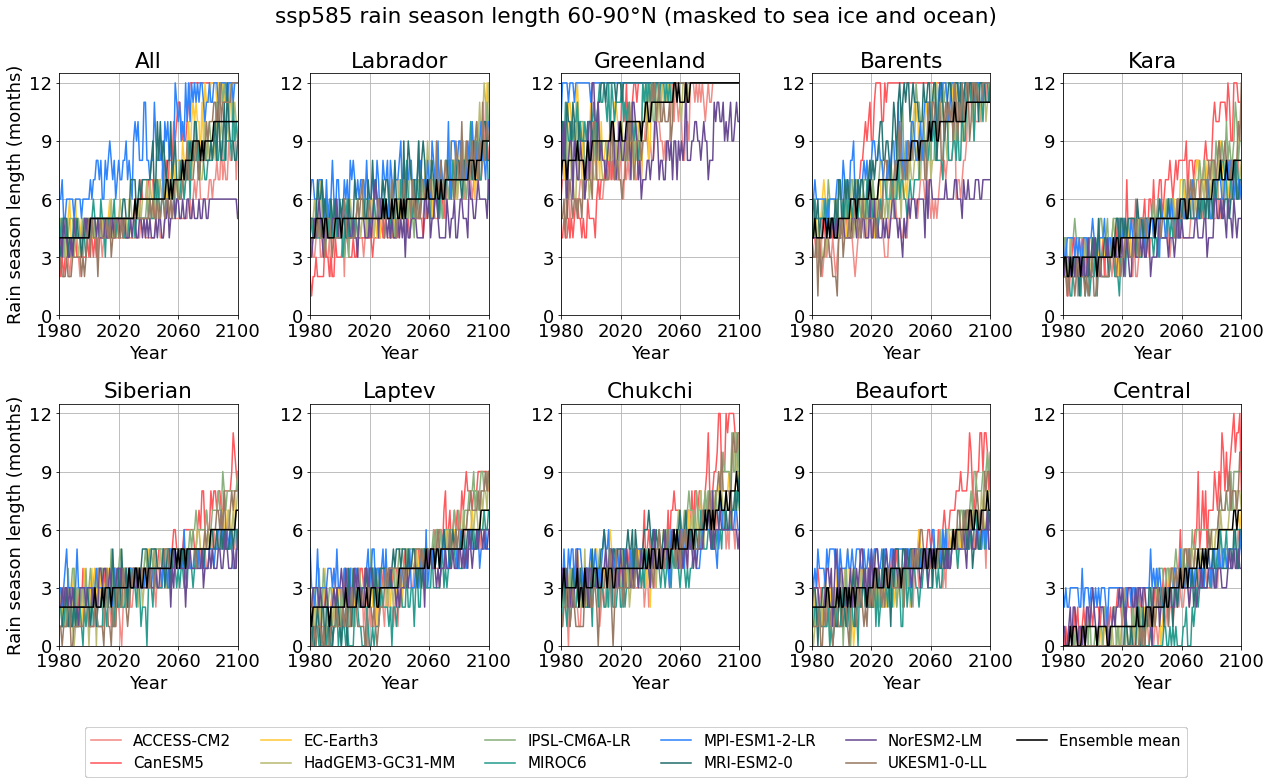

In [10]:
def calc_rain_season_length(prra, prsn):
    ensemble_rain_season_length = prra.copy()
    for key in ensemble_rain_season_length:
        ensemble_rain_season_length[key] = ensemble_rain_season_length[key]\
            .where(prra[key] > prsn[key])\
            .groupby('time.year')\
            .count('time')
        
        ensemble_rain_season_length[key].attrs['plot_kwargs'] = { 'linestyle': 'solid' }
        
    ensemble_rain_season_length = libs.ensemble.calc_variable_mean(ensemble_rain_season_length, to_array='time')
    ensemble_rain_season_length['Ensemble mean'] = ensemble_rain_season_length['Ensemble mean'].round()
    ensemble_rain_season_length['Ensemble mean'].attrs['plot_kwargs'] = { 'linestyle': 'solid' }
    
    return ensemble_rain_season_length


regions_prra = libs.local.get_ensemble_regional_series('prra', experiment)
regions_prsn = libs.local.get_ensemble_regional_series('prsn', experiment)

fig, axes = plt.subplots(*(2, 5), figsize=(18, 10))
axes = axes.flatten()
fig.suptitle(f'{experiment} rain season length 60-90°N (masked to sea ice and ocean)')

ensemble_rain_season_length_all = calc_rain_season_length(ensemble_prra_time_series, ensemble_prsn_time_series)

fig = libs.plot.time_series_from_vars(
    [
        ensemble_rain_season_length_all
    ],
    ax=axes[0],
    fig=fig,
    xattr='year',
    ylabel='Rain season length (months)',
    yrange=(0, 12.5)
)

axes[0].set_title('All')
axes[0].set_xticks([1980, 2020, 2060, 2100])
axes[0].set_yticks([0, 3, 6, 9, 12])

regions_rain_season_length = []

for i, data_prra in enumerate(regions_prra):
    ensemble_rain_season_length = data_prra.copy()
    data_prsn = regions_prsn[i]
    region = data_prra.attrs['region']
    
    ensemble_rain_season_length = calc_rain_season_length(data_prra, data_prsn)
    regions_rain_season_length.append(ensemble_rain_season_length)
        
    fig = libs.plot.time_series_from_vars(
        [
            ensemble_rain_season_length
        ],
        ax=axes[i + 1],
        fig=fig,
        xattr='year',
        ylabel=('Rain season length (months)' if i == 4 else ''),
        yrange=(0, 12.5)
    )
    
    axes[i + 1].set_title(region)
    axes[i + 1].set_xticks([1980, 2020, 2060, 2100])
    axes[i + 1].set_yticks([0, 3, 6, 9, 12])


fig.tight_layout()

### Correlation

In [11]:
regions_prra = libs.local.get_ensemble_regional_series('prra', experiment)
regions_pr = libs.local.get_ensemble_regional_series('pr', experiment)
regions_siconc = libs.local.get_ensemble_regional_series('siconc', experiment)
regions_tas = libs.local.get_ensemble_regional_series('tas', experiment)

corr_2080_2100_siconc = {}
corr_2080_2100_tas = {}
s_2080 = time_slices[2]
s_label = s['label']

for i, data in enumerate(regions_prra):
    data_prra = data.sel(**s['slice']).groupby('time.month').mean('time')
    data_pr = regions_pr[i].sel(**s['slice']).groupby('time.month').mean('time')
    data_siconc = regions_siconc[i].sel(**s['slice']).groupby('time.month').mean('time')
    data_tas = regions_tas[i].sel(**s['slice']).groupby('time.month').mean('time')

    data_pr_ratio = data_prra / data_pr
    data_pr_ratio.attrs = data_prra.attrs

    monthly_corr_siconc = xarray.corr(
        data_pr_ratio.to_array('variable'),
        data_siconc.to_array('variable'),
        dim='variable'
    )

    corr_2080_2100_siconc[data_siconc.attrs['region']] = monthly_corr_siconc

    corr_2080_2100_tas[data_tas.attrs['region']] = xarray.corr(
        data_pr_ratio.to_array('variable'),
        data_tas.to_array('variable'),
        dim='variable'
    )

In [12]:
arr_corr_intermodel = []

for corr_2080_2100 in [corr_2080_2100_siconc, corr_2080_2100_tas]:
    lats_lower_names = ['Labrador', 'Greenland', 'Barents']
    lats_higher_names = [key for key in corr_2080_2100 if key not in lats_lower_names]

    ds_corr_intermodel = xarray.Dataset(data_vars=corr_2080_2100)
    ds_corr_intermodel = libs.ensemble.calc_variable_mean(
        ds_corr_intermodel,
        subset=lats_lower_names,
        var_name='Mean (Lower latitude)'
    )
    ds_corr_intermodel = libs.ensemble.calc_variable_mean(
        ds_corr_intermodel,
        subset=lats_higher_names,
        var_name='Mean (Higher latitude)'
    )

    ds_corr_intermodel['Mean (Lower latitude)'].attrs['plot_kwargs'] = { 'linestyle': 'dashed', 'linewidth': 2 }
    ds_corr_intermodel['Mean (Higher latitude)'].attrs['plot_kwargs'] = { 'linestyle': 'dashdot', 'linewidth': 2 }
    
    arr_corr_intermodel.append(ds_corr_intermodel)

In [13]:
import warnings
warnings.filterwarnings('ignore')

regions_pr_ratio = []
for i, ds_prra in enumerate(regions_prra):
    data_pr_ratio = ds_prra / regions_pr[i]
    data_pr_ratio.attrs = ds_prra.attrs
    regions_pr_ratio.append(data_pr_ratio)

regions_pr_ratio_clim = [
    libs.analysis.climatology_monthly(r, '1980-01-01', '2011-01-01') for r in regions_pr_ratio
]
regions_siconc_clim = [
    libs.analysis.climatology_monthly(r, '1980-01-01', '2011-01-01') for r in regions_siconc
]
regions_tas_clim = [
    libs.analysis.climatology_monthly(r, '1980-01-01', '2011-01-01') for r in regions_tas
]

corr_ensemble_mean = {}
corr_ensemble_mean_tas = {}
for i, ds_pr_ratio_clim in enumerate(regions_pr_ratio_clim):
    ds_siconc_clim = regions_siconc_clim[i]
    ds_tas_clim = regions_tas_clim[i]
    region_corr_monthly = []
    region_corr_monthly_tas = []

    for m_i in ds_pr_ratio_clim.month[0:12]:
        test_pr_monthly = ds_pr_ratio_clim.where(ds_pr_ratio_clim.time.month == m_i, drop=True)
        test_siconc_monthly = ds_siconc_clim.where(ds_siconc_clim.time.month == m_i, drop=True)
        test_tas_monthly = ds_tas_clim.where(ds_siconc_clim.time.month == m_i, drop=True)

        region_corr_monthly.append(
            xarray.corr(
                test_pr_monthly.to_array('variable'),
                test_siconc_monthly.to_array('variable')
            )
        )
        region_corr_monthly_tas.append(
            xarray.corr(
                test_pr_monthly.to_array('variable'),
                test_tas_monthly.to_array('variable')
            )
        )
        
    corr_ensemble_mean[regions_siconc[i].attrs['region']] = (['month'], region_corr_monthly)
    corr_ensemble_mean_tas[regions_tas[i].attrs['region']] = (['month'], region_corr_monthly_tas)

In [14]:
arr_corr_ensemble_mean = []
for corr in [corr_ensemble_mean, corr_ensemble_mean_tas]:
    ds_corr_ensemble_mean = xarray.Dataset(
        data_vars=corr,
        coords={ 'month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12 ] }
    )
    ds_corr_ensemble_mean = libs.ensemble.calc_variable_mean(
        ds_corr_ensemble_mean,
        subset=lats_lower_names,
        var_name='Mean (Lower latitude)'
    )
    ds_corr_ensemble_mean = libs.ensemble.calc_variable_mean(
        ds_corr_ensemble_mean,
        subset=lats_higher_names,
        var_name='Mean (Higher latitude)'
    )

    ds_corr_ensemble_mean['Mean (Lower latitude)'].attrs['plot_kwargs'] = { 'linestyle': 'dashed', 'linewidth': 2 }
    ds_corr_ensemble_mean['Mean (Higher latitude)'].attrs['plot_kwargs'] = { 'linestyle': 'dashdot', 'linewidth': 2 }
    
    arr_corr_ensemble_mean.append(ds_corr_ensemble_mean)

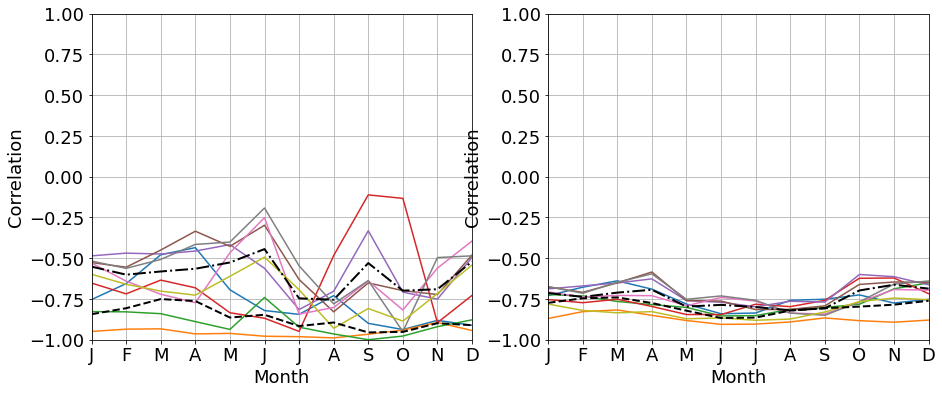

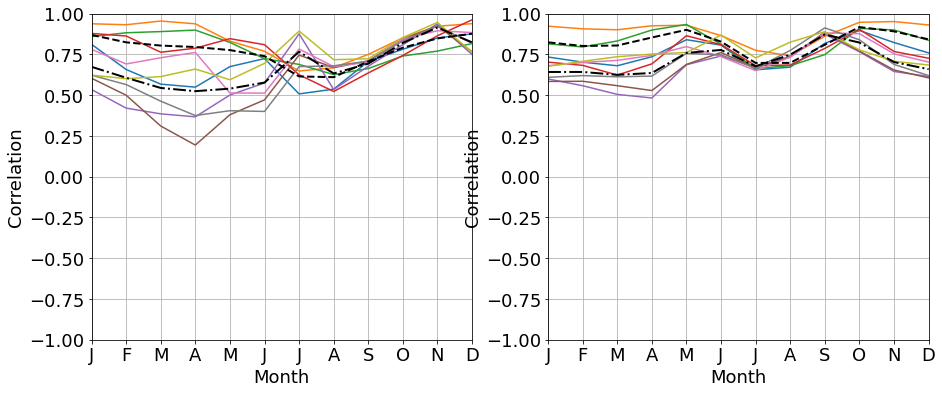

In [15]:
for i, ds_corr_intermodel in enumerate(arr_corr_intermodel):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes = axes.flatten()
    ds_corr_ensemble_mean = arr_corr_ensemble_mean[i]
    # fig.suptitle(
    #     f'''{experiment} Correlation between prra/pr and siarea & tas
    #     (a) inter-model spatial average 2080-2100 and 
    #     (b) ensemble mean across 1980-2100 anom 1980-2010 60-90°N'''
    # )

    libs.plot.monthly_variability(
        ds_corr_intermodel,
        ax=axes[0],
        fig=fig,
        show_legend=False,
        ylabel='Correlation',
        yrange=(-1, 1)
    );

    libs.plot.monthly_variability(
        ds_corr_ensemble_mean,
        ax=axes[1],
        fig=fig,
        show_legend=False,
        ylabel='Correlation',
        yrange=(-1, 1)
    );

#     libs.plot.legend_standalone(
#         fig,
#         legend_confs=[
#             { 'ncol': 5, 'exclude': [] },
#             { 'ncol': 6, 'exclude': [] },
#         ]
#     )

### Rain season first month

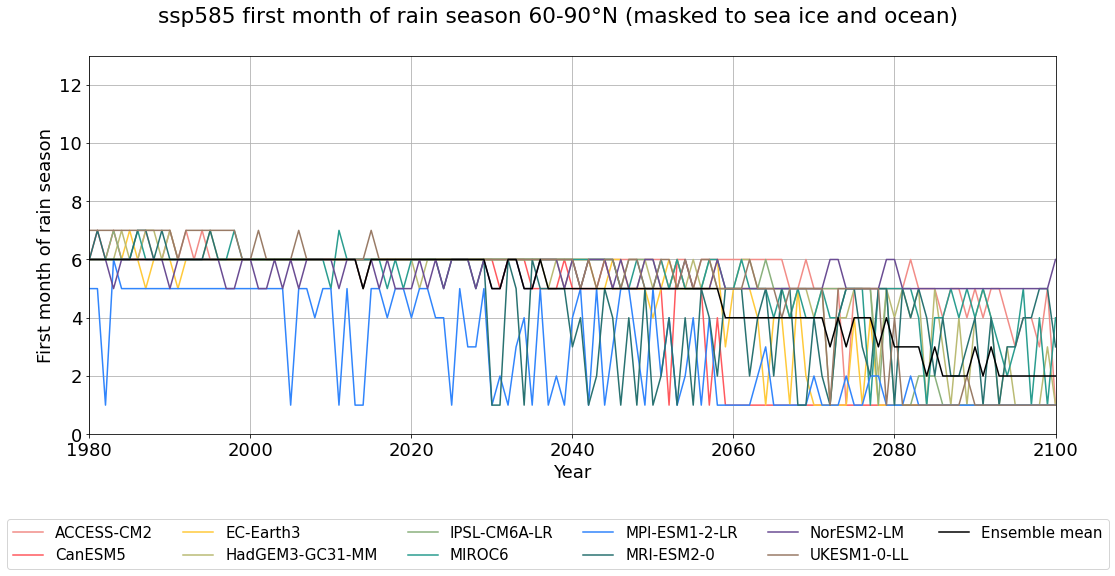

In [16]:
def get_first_month(x):
    for i, v in enumerate(x.values):
        if np.isnan(v):
            continue
            
        return x.time.values[i].month
    
    return np.nan


def create_first_month_dataset(base_series, ensemble_prra_time_series, ensemble_prsn_time_series):
    ensemble_rain_season_month = base_series.copy()
    data_vars = {}
    years = []
    for key in ensemble_rain_season_month:
        grouped = ensemble_rain_season_month[key]\
            .where(ensemble_prra_time_series[key] > ensemble_prsn_time_series[key])\
            .groupby('time.year')

        years = [year_ds[0] for year_ds in grouped]
        vals = [get_first_month(year_ds[1]) for year_ds in grouped]

        data_vars[key] = ('year', vals)


    ensemble_rain_season_month = xarray.Dataset(
        data_vars=data_vars,
        coords={ 'year': years }
    )
    
    for key in ensemble_rain_season_month:
        ensemble_rain_season_month[key].attrs = base_series[key].attrs

    ensemble_rain_season_month = libs.ensemble.calc_variable_mean(ensemble_rain_season_month, to_array='time')
    ensemble_rain_season_month['Ensemble mean'] = ensemble_rain_season_month['Ensemble mean'].round()
    
    return ensemble_rain_season_month


ensemble_rain_season_month_all = create_first_month_dataset(
    ensemble_pr_time_series,
    ensemble_prra_time_series,
    ensemble_prsn_time_series
)

fig = libs.plot.time_series_from_vars(
    [
        ensemble_rain_season_month_all
    ],
    title=f'{experiment} first month of rain season 60-90°N (masked to sea ice and ocean)',
    xattr='year',
    ylabel='First month of rain season',
    yrange=(0, 13)
);

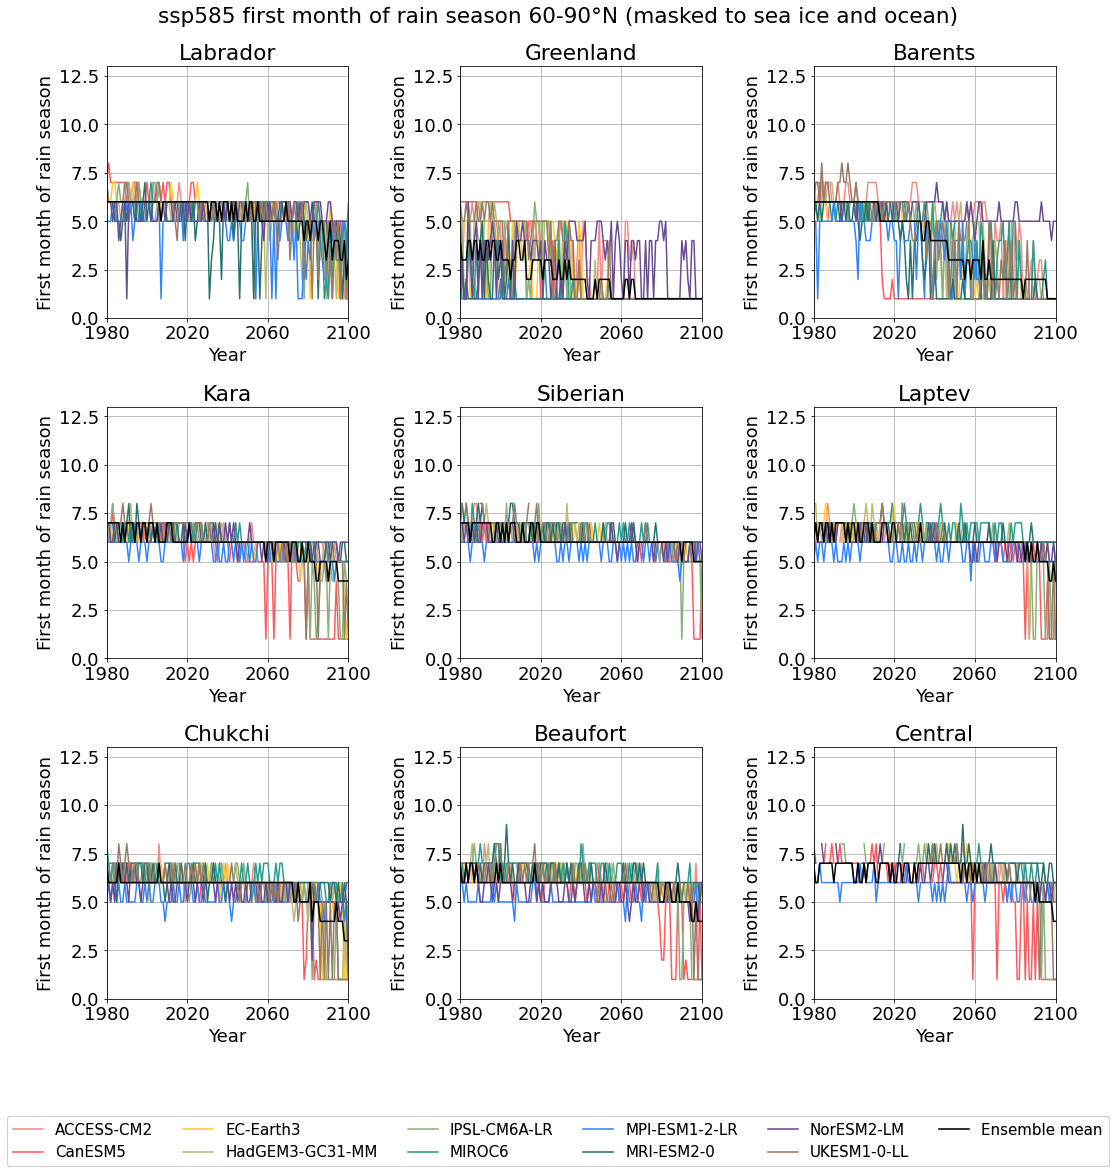

In [17]:
fig, axes = plt.subplots(*(3, 3), figsize=(15, 15))
axes = axes.flatten()
fig.suptitle(f'{experiment} first month of rain season 60-90°N (masked to sea ice and ocean)')

for i, data_prra in enumerate(regions_prra):
    data_prsn = regions_prsn[i]
    region = data_prra.attrs['region']
    
    ensemble_rain_season_month = create_first_month_dataset(
        data_prra,
        data_prra,
        data_prsn
    )
        
    fig = libs.plot.time_series_from_vars(
        [
            ensemble_rain_season_month
        ],
        ax=axes[i],
        fig=fig,
        xattr='year',
        ylabel='First month of rain season',
        yrange=(0, 13)
    )
    
    axes[i].set_title(region)
    axes[i].set_xticks([1980, 2020, 2060, 2100])